Imports

In [1]:
!pip install scikit-learn pandas tqdm kaggle matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 1.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 4.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.2/155.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 31.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 48.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 64.4 MB/s eta 0:00:0000:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 54.4 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

In [2]:
!sudo apt install zip unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  unzip zip
0 upgraded, 2 newly installed, 0 to remove and 15 not upgraded.
Need to get 335 kB of archives.
After this operation, 1231 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 unzip amd64 6.0-25ubuntu1.1 [168 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 zip amd64 3.0-11build1 [167 kB]
Fetched 335 kB in 0s (1002 kB/s)
debconf: delaying package configuration, since apt-utils is not installed

78Selecting previously unselected package unzip.
(Reading database ... 17208 files and directories currently installed.)
Preparing to unpack .../unzip_6.0-25ubuntu1.1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [ 11%] [######....................................................] 8Unpacking unzip (6.0-25ubuntu1.1) ...

In [3]:
!chmod 600 kaggle.json  # Ensure the file is private
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d trolukovich/food11-image-dataset
!unzip -q food11-image-dataset.zip -d food11_dataset

100%|█████████████████████████████████████▉| 1.08G/1.08G [00:35<00:00, 35.6MB/s]
100%|██████████████████████████████████████| 1.08G/1.08G [00:36<00:00, 32.3MB/s]


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torchvision import datasets, transforms, models
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import pickle
from datetime import datetime

In [6]:
model_save_dir = '/Trained_Models'
os.makedirs(model_save_dir, exist_ok=True)  # Create the directory if it doesn't exist

Data Loading and Preprocessing

In [7]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
train_dataset = datasets.ImageFolder(root='food11_dataset/training', transform=transform)
val_dataset = datasets.ImageFolder(root='food11_dataset/validation', transform=transform)
test_dataset = datasets.ImageFolder(root='food11_dataset/evaluation', transform=transform)

# DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)


Model Definitions

In [8]:
def get_model(pretrained=True):
    return {
        'EfficientNet': models.efficientnet_v2_s(pretrained=pretrained),
        'ResNet': models.resnet50(pretrained=pretrained),
        'VGG': models.vgg16(pretrained=pretrained),
        'MobileNet': models.mobilenet_v3_large(pretrained=pretrained),
        'DenseNet': models.densenet121(pretrained=pretrained)
    }

def modify_model_classes(model_dict, num_classes):
    for name, model in model_dict.items():
        if name == 'EfficientNet':
            num_ftrs = model.classifier[1].in_features
            model.classifier[1] = torch.nn.Linear(num_ftrs, num_classes)
        elif name == 'ResNet':
            num_ftrs = model.fc.in_features
            model.fc = torch.nn.Linear(num_ftrs, num_classes)
        elif name == 'VGG':
            num_ftrs = model.classifier[6].in_features
            model.classifier[6] = torch.nn.Linear(num_ftrs, num_classes)
        elif name == 'MobileNet':
            num_ftrs = model.classifier[3].in_features
            model.classifier[3] = torch.nn.Linear(num_ftrs, num_classes)
        elif name == 'DenseNet':
            num_ftrs = model.classifier.in_features
            model.classifier = torch.nn.Linear(num_ftrs, num_classes)
    return model_dict

In [9]:
pretrained_models = modify_model_classes(get_model(pretrained=True), num_classes=11)
non_pretrained_models = modify_model_classes(get_model(pretrained=False), num_classes=11)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:01<00:00, 65.9MB/s]
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are depre

Training and Evaluation

In [10]:
def train_and_validate_model(model, train_loader, val_loader, epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    scaler = GradScaler()

    best_val_accuracy = 0

    # Lists to store per epoch metrics
    epoch_train_losses = []
    epoch_train_accuracies = []
    epoch_val_losses = []
    epoch_val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_accuracy = train_correct / train_total
        epoch_train_losses.append(train_loss / len(train_loader))
        epoch_train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = val_correct / val_total

        epoch_val_losses.append(val_loss / len(val_loader))
        epoch_val_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}, Val Accuracy: {val_accuracy}')

        # Update best model if validation accuracy improves
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_wts = model.state_dict()

        scheduler.step()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_train_losses, epoch_train_accuracies, epoch_val_losses, epoch_val_accuracies


In [11]:
def evaluate_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    accuracy = accuracy_score(all_labels, all_preds)

    return precision, recall, f1, accuracy

In [12]:
def train_and_evaluate_models(model_dict, pretrained_status, epochs=10):
    results_df = pd.DataFrame(columns=['Model', 'Pretrained', 'Precision', 'Recall', 'F1 Score', 'Accuracy'])

    metrics_dict = {}
    
    for name, model in model_dict.items():
        print(f"Training and validating {name} (Pretrained: {pretrained_status})")
        trained_model, train_losses, train_accuracies, val_losses, val_accuracies = train_and_validate_model(model, train_loader, val_loader, epochs=epochs)

        # Store metrics for plotting
        metrics_dict[name] = {
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies
        }

        # Saving the trained model
        model_path = os.path.join(model_save_dir, f'{name}_{"pretrained" if pretrained_status else "non_pretrained"}.pt')
        torch.save(trained_model.state_dict(), model_path)
        print(f"Saved trained model at {model_path}")
        
        print(f"Evaluating {name} (Pretrained: {pretrained_status})")
        precision, recall, f1, accuracy = evaluate_model(trained_model, test_loader)
        print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}, Accuracy: {accuracy}")
        results_df.loc[len(results_df.index)] = [name, pretrained_status, precision, recall, f1, accuracy]
        
    return results_df, metrics_dict

In [13]:
# Train and evaluate pretrained models
pretrained_results_df, pretrained_metrics = train_and_evaluate_models(pretrained_models, True)

Training and validating EfficientNet (Pretrained: True)


100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Epoch 1/10, Train Loss: 0.6207414911343501, Val Loss: 0.5134399991344523, Val Accuracy: 0.8411078717201166


100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Epoch 2/10, Train Loss: 0.2600300457233038, Val Loss: 0.6421071920129988, Val Accuracy: 0.8119533527696793


100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Epoch 3/10, Train Loss: 0.22063683804411155, Val Loss: 0.43681781573428047, Val Accuracy: 0.8737609329446064


100%|██████████| 78/78 [00:18<00:00,  4.27it/s]


Epoch 4/10, Train Loss: 0.1188281175847619, Val Loss: 0.4215328287747171, Val Accuracy: 0.8865889212827989


100%|██████████| 78/78 [00:18<00:00,  4.20it/s]


Epoch 5/10, Train Loss: 0.1350584694972405, Val Loss: 0.5293610785846357, Val Accuracy: 0.8565597667638484


100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Epoch 6/10, Train Loss: 0.12732596437518412, Val Loss: 0.5274091589230078, Val Accuracy: 0.8635568513119534


100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Epoch 7/10, Train Loss: 0.09944040793925524, Val Loss: 0.5303182146615453, Val Accuracy: 0.8717201166180758


100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Epoch 8/10, Train Loss: 0.03758142513628954, Val Loss: 0.33827447753261636, Val Accuracy: 0.9209912536443149


100%|██████████| 78/78 [00:18<00:00,  4.29it/s]


Epoch 9/10, Train Loss: 0.012381728917646866, Val Loss: 0.3283819023657728, Val Accuracy: 0.9215743440233236


100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


Epoch 10/10, Train Loss: 0.010888295761572245, Val Loss: 0.31590965666152815, Val Accuracy: 0.922740524781341
Saved trained model at /Trained_Models/EfficientNet_pretrained.pt
Evaluating EfficientNet (Pretrained: True)
Precision: 0.9406910438415294, Recall: 0.9405437705407828, F1 Score: 0.9404485231034166, Accuracy: 0.9405437705407828
Training and validating ResNet (Pretrained: True)


100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Epoch 1/10, Train Loss: 0.9316233312472318, Val Loss: 1.4890273434144479, Val Accuracy: 0.6064139941690962


100%|██████████| 78/78 [00:18<00:00,  4.22it/s]


Epoch 2/10, Train Loss: 0.6709200510611901, Val Loss: 1.3790847478365456, Val Accuracy: 0.61399416909621


100%|██████████| 78/78 [00:18<00:00,  4.19it/s]


Epoch 3/10, Train Loss: 0.4657136889604422, Val Loss: 0.7994721002048917, Val Accuracy: 0.7466472303206997


100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Epoch 4/10, Train Loss: 0.3622863414004827, Val Loss: 1.0489730917745166, Val Accuracy: 0.7017492711370262


100%|██████████| 78/78 [00:18<00:00,  4.18it/s]


Epoch 5/10, Train Loss: 0.25046747273359543, Val Loss: 0.8534409210637763, Val Accuracy: 0.7746355685131195


100%|██████████| 78/78 [00:18<00:00,  4.30it/s]


Epoch 6/10, Train Loss: 0.2323455646252021, Val Loss: 0.8352419521521639, Val Accuracy: 0.7638483965014577


100%|██████████| 78/78 [00:18<00:00,  4.23it/s]


Epoch 7/10, Train Loss: 0.3161046174474252, Val Loss: 1.3434642409836803, Val Accuracy: 0.6775510204081633


100%|██████████| 78/78 [00:18<00:00,  4.20it/s]


Epoch 8/10, Train Loss: 0.1432973809349231, Val Loss: 0.5144792684802303, Val Accuracy: 0.8475218658892129


100%|██████████| 78/78 [00:18<00:00,  4.22it/s]


Epoch 9/10, Train Loss: 0.03632131832627914, Val Loss: 0.4958893264885302, Val Accuracy: 0.860932944606414


100%|██████████| 78/78 [00:18<00:00,  4.19it/s]


Epoch 10/10, Train Loss: 0.02448372610916312, Val Loss: 0.5072234973863319, Val Accuracy: 0.8629737609329446
Saved trained model at /Trained_Models/ResNet_pretrained.pt
Evaluating ResNet (Pretrained: True)
Precision: 0.8832925073166292, Recall: 0.8837765162832387, F1 Score: 0.8832656322694598, Accuracy: 0.8837765162832387
Training and validating VGG (Pretrained: True)


100%|██████████| 78/78 [00:18<00:00,  4.22it/s]


Epoch 1/10, Train Loss: 2.8376557613030458, Val Loss: 2.179447344055882, Val Accuracy: 0.2381924198250729


100%|██████████| 78/78 [00:18<00:00,  4.19it/s]


Epoch 2/10, Train Loss: 2.1112957780177775, Val Loss: 1.9982974529266357, Val Accuracy: 0.29620991253644313


100%|██████████| 78/78 [00:18<00:00,  4.18it/s]


Epoch 3/10, Train Loss: 1.9628670475421808, Val Loss: 1.9103485500371014, Val Accuracy: 0.32157434402332363


100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


Epoch 4/10, Train Loss: 1.952303681618128, Val Loss: 2.0689749938470348, Val Accuracy: 0.30670553935860057


100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Epoch 5/10, Train Loss: 1.720157279418065, Val Loss: 1.6395078853324607, Val Accuracy: 0.4002915451895044


100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Epoch 6/10, Train Loss: 1.5798499935712569, Val Loss: 1.6442777978049383, Val Accuracy: 0.41953352769679303


100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Epoch 7/10, Train Loss: 1.4582267900307972, Val Loss: 1.5225156799510673, Val Accuracy: 0.4553935860058309


100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Epoch 8/10, Train Loss: 1.19905098202901, Val Loss: 1.2638486800370392, Val Accuracy: 0.5443148688046647


100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Epoch 9/10, Train Loss: 1.092298075174674, Val Loss: 1.2211612738944866, Val Accuracy: 0.5597667638483965


100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


Epoch 10/10, Train Loss: 1.0125997127630773, Val Loss: 1.222129848268297, Val Accuracy: 0.5629737609329446
Saved trained model at /Trained_Models/VGG_pretrained.pt
Evaluating VGG (Pretrained: True)
Precision: 0.5951369511695941, Recall: 0.5945622945921721, F1 Score: 0.588476268528183, Accuracy: 0.5945622945921721
Training and validating MobileNet (Pretrained: True)


100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


Epoch 1/10, Train Loss: 0.6442914051123154, Val Loss: 0.926808096744396, Val Accuracy: 0.7335276967930029


100%|██████████| 78/78 [00:18<00:00,  4.18it/s]


Epoch 2/10, Train Loss: 0.23931114614391938, Val Loss: 0.8506897994213634, Val Accuracy: 0.7935860058309038


100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Epoch 3/10, Train Loss: 0.12244631507648872, Val Loss: 0.9063295666818265, Val Accuracy: 0.7947521865889213


100%|██████████| 78/78 [00:18<00:00,  4.24it/s]


Epoch 4/10, Train Loss: 0.10475279451109087, Val Loss: 0.7204580664358757, Val Accuracy: 0.8224489795918367


100%|██████████| 78/78 [00:18<00:00,  4.22it/s]


Epoch 5/10, Train Loss: 0.07067110616331682, Val Loss: 0.5869505267452311, Val Accuracy: 0.8396501457725948


100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Epoch 6/10, Train Loss: 0.07570025285419363, Val Loss: 0.9323913457768934, Val Accuracy: 0.8075801749271136


100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Epoch 7/10, Train Loss: 0.15672207129402801, Val Loss: 0.7012200410719271, Val Accuracy: 0.8551020408163266


100%|██████████| 78/78 [00:18<00:00,  4.18it/s]


Epoch 8/10, Train Loss: 0.03510276821609109, Val Loss: 0.4497350291521461, Val Accuracy: 0.8947521865889213


100%|██████████| 78/78 [00:18<00:00,  4.24it/s]


Epoch 9/10, Train Loss: 0.013041004705696534, Val Loss: 0.41009484976530075, Val Accuracy: 0.9011661807580175


100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


Epoch 10/10, Train Loss: 0.00810326219130403, Val Loss: 0.39929168340232635, Val Accuracy: 0.9052478134110787
Saved trained model at /Trained_Models/MobileNet_pretrained.pt
Evaluating MobileNet (Pretrained: True)
Precision: 0.9287181103727855, Recall: 0.9282939946220496, F1 Score: 0.9281924311116344, Accuracy: 0.9282939946220496
Training and validating DenseNet (Pretrained: True)


100%|██████████| 78/78 [00:19<00:00,  4.11it/s]


Epoch 1/10, Train Loss: 0.6951421273824496, Val Loss: 0.7218232204516729, Val Accuracy: 0.7673469387755102


100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


Epoch 2/10, Train Loss: 0.3871415165754465, Val Loss: 0.5745470744592173, Val Accuracy: 0.8247813411078717


100%|██████████| 78/78 [00:18<00:00,  4.27it/s]


Epoch 3/10, Train Loss: 0.284557928928198, Val Loss: 0.7094008003671964, Val Accuracy: 0.7915451895043731


100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


Epoch 4/10, Train Loss: 0.19604551983185303, Val Loss: 0.5402259142310532, Val Accuracy: 0.8364431486880467


100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Epoch 5/10, Train Loss: 0.14566717879512373, Val Loss: 0.9766827076673508, Val Accuracy: 0.7457725947521866


100%|██████████| 78/78 [00:18<00:00,  4.22it/s]


Epoch 6/10, Train Loss: 0.19048805143206549, Val Loss: 1.0181913500030835, Val Accuracy: 0.7206997084548105


100%|██████████| 78/78 [00:18<00:00,  4.18it/s]


Epoch 7/10, Train Loss: 0.22153987487157187, Val Loss: 0.8335191309452057, Val Accuracy: 0.7833819241982507


100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


Epoch 8/10, Train Loss: 0.07018518187583257, Val Loss: 0.3840372777647442, Val Accuracy: 0.8862973760932945


100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Epoch 9/10, Train Loss: 0.023590359741296522, Val Loss: 0.3698368177369789, Val Accuracy: 0.893002915451895


100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Epoch 10/10, Train Loss: 0.017891645431518555, Val Loss: 0.3679029610421922, Val Accuracy: 0.8956268221574344
Saved trained model at /Trained_Models/DenseNet_pretrained.pt
Evaluating DenseNet (Pretrained: True)
Precision: 0.9245153592283861, Recall: 0.9241111443083359, F1 Score: 0.9240450252487148, Accuracy: 0.9241111443083359


In [14]:
pretrained_results_df

,Model,Pretrained,Precision,Recall,F1 Score,Accuracy
0,EfficientNet,True,0.940691,0.940544,0.940449,0.940544
1,ResNet,True,0.883293,0.883777,0.883266,0.883777
2,VGG,True,0.595137,0.594562,0.588476,0.594562
3,MobileNet,True,0.928718,0.928294,0.928192,0.928294
4,DenseNet,True,0.924515,0.924111,0.924045,0.924111


In [15]:
current_timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
filename = f'results_pretrained_{current_timestamp}.csv'
pretrained_results_df.to_csv(filename)

In [16]:
# Train and evaluate non-pretrained models
non_pretrained_results_df, non_pretrained_metrics = train_and_evaluate_models(non_pretrained_models, False, epochs=20)

Training and validating EfficientNet (Pretrained: False)


100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Epoch 1/20, Train Loss: 2.202376753855974, Val Loss: 7.868126615330025, Val Accuracy: 0.19096209912536444


100%|██████████| 78/78 [00:18<00:00,  4.26it/s]


Epoch 2/20, Train Loss: 2.090577620726365, Val Loss: 2.7675787519525596, Val Accuracy: 0.2731778425655977


100%|██████████| 78/78 [00:18<00:00,  4.28it/s]


Epoch 3/20, Train Loss: 2.0033913178321643, Val Loss: 2.0580044852362738, Val Accuracy: 0.2790087463556851


100%|██████████| 78/78 [00:18<00:00,  4.18it/s]


Epoch 4/20, Train Loss: 1.9105864702126918, Val Loss: 1.8165192780671295, Val Accuracy: 0.36793002915451894


100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


Epoch 5/20, Train Loss: 1.8197722664246192, Val Loss: 1.790179901652866, Val Accuracy: 0.37900874635568516


100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Epoch 6/20, Train Loss: 1.7089841212981787, Val Loss: 1.7179104089736938, Val Accuracy: 0.41720116618075803


100%|██████████| 78/78 [00:18<00:00,  4.27it/s]


Epoch 7/20, Train Loss: 1.6132662739509191, Val Loss: 1.8047995037502713, Val Accuracy: 0.3889212827988338


100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


Epoch 8/20, Train Loss: 1.4458432243420527, Val Loss: 1.4004077514012654, Val Accuracy: 0.5157434402332362


100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


Epoch 9/20, Train Loss: 1.334589504278623, Val Loss: 1.3664063855453774, Val Accuracy: 0.5192419825072886


100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Epoch 10/20, Train Loss: 1.2846682698298724, Val Loss: 1.3550356383676883, Val Accuracy: 0.5291545189504373


100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Epoch 11/20, Train Loss: 1.2514035762884679, Val Loss: 1.3127323389053345, Val Accuracy: 0.5486880466472304


100%|██████████| 78/78 [00:19<00:00,  3.90it/s]


Epoch 12/20, Train Loss: 1.1908089403922741, Val Loss: 1.3267779383394454, Val Accuracy: 0.5472303206997085


100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


Epoch 13/20, Train Loss: 1.1482296693019378, Val Loss: 1.2698190764144615, Val Accuracy: 0.5653061224489796


100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Epoch 14/20, Train Loss: 1.0928448797800603, Val Loss: 1.2630013867660805, Val Accuracy: 0.5766763848396501


100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


Epoch 15/20, Train Loss: 1.0198673002230816, Val Loss: 1.2492194793842457, Val Accuracy: 0.574927113702624


100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Epoch 16/20, Train Loss: 0.9772985187860636, Val Loss: 1.2401056631847664, Val Accuracy: 0.5807580174927114


100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Epoch 17/20, Train Loss: 0.9687473147343366, Val Loss: 1.240620215733846, Val Accuracy: 0.5825072886297377


100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


Epoch 18/20, Train Loss: 0.9439269143801469, Val Loss: 1.2372229474562186, Val Accuracy: 0.5874635568513119


100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Epoch 19/20, Train Loss: 0.954501211643219, Val Loss: 1.2411005276220817, Val Accuracy: 0.5886297376093295


100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Epoch 20/20, Train Loss: 0.9317514315629617, Val Loss: 1.2409996368266918, Val Accuracy: 0.5857142857142857
Saved trained model at /Trained_Models/EfficientNet_non_pretrained.pt
Evaluating EfficientNet (Pretrained: False)
Precision: 0.6038512382689586, Recall: 0.6074096205557216, F1 Score: 0.6041210598105653, Accuracy: 0.6074096205557216
Training and validating ResNet (Pretrained: False)


100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Epoch 1/20, Train Loss: 2.1350047206267333, Val Loss: 2.0415613518820868, Val Accuracy: 0.31370262390670556


100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Epoch 2/20, Train Loss: 1.8127866830581274, Val Loss: 2.0919823701734894, Val Accuracy: 0.3163265306122449


100%|██████████| 78/78 [00:18<00:00,  4.20it/s]


Epoch 3/20, Train Loss: 1.7525919691110268, Val Loss: 2.010052371908117, Val Accuracy: 0.3454810495626822


100%|██████████| 78/78 [00:20<00:00,  3.86it/s]


Epoch 4/20, Train Loss: 1.6683320555931482, Val Loss: 2.123876178706134, Val Accuracy: 0.3545189504373178


100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Epoch 5/20, Train Loss: 1.6980747213730445, Val Loss: 2.195461904561078, Val Accuracy: 0.34169096209912536


100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Epoch 6/20, Train Loss: 1.5259939355727954, Val Loss: 2.4099319334383362, Val Accuracy: 0.3947521865889213


100%|██████████| 78/78 [00:18<00:00,  4.18it/s]


Epoch 7/20, Train Loss: 1.491340316258944, Val Loss: 1.7867540452215407, Val Accuracy: 0.42448979591836733


100%|██████████| 78/78 [00:18<00:00,  4.22it/s]


Epoch 8/20, Train Loss: 1.2720308372607598, Val Loss: 1.293949959454713, Val Accuracy: 0.5603498542274052


100%|██████████| 78/78 [00:18<00:00,  4.24it/s]


Epoch 9/20, Train Loss: 1.173629296895785, Val Loss: 1.274350025035717, Val Accuracy: 0.566472303206997


100%|██████████| 78/78 [00:18<00:00,  4.19it/s]


Epoch 10/20, Train Loss: 1.1390141309835973, Val Loss: 1.2740628675178245, Val Accuracy: 0.563265306122449


100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Epoch 11/20, Train Loss: 1.1161347008668459, Val Loss: 1.2463226185904608, Val Accuracy: 0.5723032069970846


100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Epoch 12/20, Train Loss: 1.061635720424163, Val Loss: 1.284717857837677, Val Accuracy: 0.5708454810495627


100%|██████████| 78/78 [00:19<00:00,  4.00it/s]


Epoch 13/20, Train Loss: 1.015117701047506, Val Loss: 1.2475674395208005, Val Accuracy: 0.582798833819242


100%|██████████| 78/78 [00:18<00:00,  4.29it/s]


Epoch 14/20, Train Loss: 0.993098429380319, Val Loss: 1.2635476765809235, Val Accuracy: 0.582798833819242


100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Epoch 15/20, Train Loss: 0.9043369415478829, Val Loss: 1.1715470883581374, Val Accuracy: 0.6029154518950437


100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Epoch 16/20, Train Loss: 0.873467709009464, Val Loss: 1.1668279744960643, Val Accuracy: 0.605539358600583


100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


Epoch 17/20, Train Loss: 0.8553663690884908, Val Loss: 1.1698582304848566, Val Accuracy: 0.6081632653061224


100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


Epoch 18/20, Train Loss: 0.8494649155017657, Val Loss: 1.1747953648920413, Val Accuracy: 0.6043731778425656


100%|██████████| 78/78 [00:18<00:00,  4.26it/s]


Epoch 19/20, Train Loss: 0.8380482632380265, Val Loss: 1.1774508202517475, Val Accuracy: 0.6142857142857143


100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


Epoch 20/20, Train Loss: 0.8248238884485685, Val Loss: 1.175267427055924, Val Accuracy: 0.6061224489795919
Saved trained model at /Trained_Models/ResNet_non_pretrained.pt
Evaluating ResNet (Pretrained: False)
Precision: 0.637992519328459, Recall: 0.6447564983567374, F1 Score: 0.6400822227217144, Accuracy: 0.6447564983567374
Training and validating VGG (Pretrained: False)


100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


Epoch 1/20, Train Loss: 12.939811981641329, Val Loss: 2.296123676829868, Val Accuracy: 0.1457725947521866


100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


Epoch 2/20, Train Loss: 2.2933776653729954, Val Loss: 2.2321368720796375, Val Accuracy: 0.19183673469387755


100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


Epoch 3/20, Train Loss: 2.221488335193732, Val Loss: 2.184606578614977, Val Accuracy: 0.2078717201166181


100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Epoch 4/20, Train Loss: 2.1386798528524547, Val Loss: 2.1160480667043617, Val Accuracy: 0.23731778425655978


100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Epoch 5/20, Train Loss: 2.089183602577601, Val Loss: 2.068102655587373, Val Accuracy: 0.24606413994169096


100%|██████████| 78/78 [00:19<00:00,  3.98it/s]


Epoch 6/20, Train Loss: 2.0371805612857523, Val Loss: 2.00150254479161, Val Accuracy: 0.26822157434402333


100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


Epoch 7/20, Train Loss: 1.982131954951164, Val Loss: 1.987302373956751, Val Accuracy: 0.2909620991253644


100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Epoch 8/20, Train Loss: 1.878467816572923, Val Loss: 1.9144311260294031, Val Accuracy: 0.31865889212827986


100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Epoch 9/20, Train Loss: 1.8396422878289833, Val Loss: 1.8894253726358767, Val Accuracy: 0.324198250728863


100%|██████████| 78/78 [00:18<00:00,  4.23it/s]


Epoch 10/20, Train Loss: 1.8084698166602697, Val Loss: 1.8680223160319858, Val Accuracy: 0.324198250728863


100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Epoch 11/20, Train Loss: 1.777855830314832, Val Loss: 1.8455746394616586, Val Accuracy: 0.33760932944606414


100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Epoch 12/20, Train Loss: 1.745836520806337, Val Loss: 1.8449296377323292, Val Accuracy: 0.34052478134110786


100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Epoch 13/20, Train Loss: 1.7111782462168963, Val Loss: 1.8220596931598805, Val Accuracy: 0.3478134110787172


100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Epoch 14/20, Train Loss: 1.6539336290114965, Val Loss: 1.8015895375499018, Val Accuracy: 0.35539358600583093


100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Epoch 15/20, Train Loss: 1.5855950850706835, Val Loss: 1.7963753916599132, Val Accuracy: 0.36064139941690965


100%|██████████| 78/78 [00:18<00:00,  4.20it/s]


Epoch 16/20, Train Loss: 1.5750023753215106, Val Loss: 1.8030056489838495, Val Accuracy: 0.3618075801749271


100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Epoch 17/20, Train Loss: 1.5614547698925703, Val Loss: 1.7998209838513974, Val Accuracy: 0.36355685131195337


100%|██████████| 78/78 [00:18<00:00,  4.22it/s]


Epoch 18/20, Train Loss: 1.548937773093199, Val Loss: 1.804567727777693, Val Accuracy: 0.36268221574344023


100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Epoch 19/20, Train Loss: 1.553399926576859, Val Loss: 1.7982320542688723, Val Accuracy: 0.36239067055393587


100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Epoch 20/20, Train Loss: 1.5371726552645366, Val Loss: 1.8040116363101535, Val Accuracy: 0.36268221574344023
Saved trained model at /Trained_Models/VGG_non_pretrained.pt
Evaluating VGG (Pretrained: False)
Precision: 0.38681914396519235, Recall: 0.39617567971317597, F1 Score: 0.383632207864238, Accuracy: 0.39617567971317597
Training and validating MobileNet (Pretrained: False)


100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Epoch 1/20, Train Loss: 2.015296155061477, Val Loss: 2.351868236506427, Val Accuracy: 0.1457725947521866


100%|██████████| 78/78 [00:18<00:00,  4.31it/s]


Epoch 2/20, Train Loss: 1.719211173363221, Val Loss: 2.3947167793909707, Val Accuracy: 0.1457725947521866


100%|██████████| 78/78 [00:18<00:00,  4.26it/s]


Epoch 3/20, Train Loss: 1.5742052380855267, Val Loss: 2.6292058803417064, Val Accuracy: 0.1457725947521866


100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Epoch 4/20, Train Loss: 1.4314835973275013, Val Loss: 2.696529909416481, Val Accuracy: 0.1457725947521866


100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


Epoch 5/20, Train Loss: 1.3079353532730005, Val Loss: 2.8950327281598693, Val Accuracy: 0.1915451895043732


100%|██████████| 78/78 [00:18<00:00,  4.26it/s]


Epoch 6/20, Train Loss: 1.1822045476008685, Val Loss: 3.0662860296390675, Val Accuracy: 0.15043731778425656


100%|██████████| 78/78 [00:19<00:00,  4.00it/s]


Epoch 7/20, Train Loss: 1.0659881088978205, Val Loss: 3.1936414263866566, Val Accuracy: 0.2075801749271137


100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Epoch 8/20, Train Loss: 0.7911862616355603, Val Loss: 2.332190509195681, Val Accuracy: 0.3230320699708455


100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Epoch 9/20, Train Loss: 0.6340578962595035, Val Loss: 1.920159309550568, Val Accuracy: 0.41778425655976675


100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


Epoch 10/20, Train Loss: 0.5471065812385999, Val Loss: 1.6704594294230144, Val Accuracy: 0.48950437317784257


100%|██████████| 78/78 [00:18<00:00,  4.20it/s]


Epoch 11/20, Train Loss: 0.49438411990801495, Val Loss: 1.667917446957694, Val Accuracy: 0.5090379008746355


100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Epoch 12/20, Train Loss: 0.3915497423746647, Val Loss: 1.6045764243161236, Val Accuracy: 0.546064139941691


100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


Epoch 13/20, Train Loss: 0.34747313325985885, Val Loss: 1.786221769120958, Val Accuracy: 0.5446064139941691


100%|██████████| 78/78 [00:18<00:00,  4.20it/s]


Epoch 14/20, Train Loss: 0.30265237047122073, Val Loss: 1.9263776474528842, Val Accuracy: 0.5463556851311954


100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


Epoch 15/20, Train Loss: 0.21563830245763826, Val Loss: 1.963336169719696, Val Accuracy: 0.563265306122449


100%|██████████| 78/78 [00:18<00:00,  4.20it/s]


Epoch 16/20, Train Loss: 0.2136973821772979, Val Loss: 2.017551433157038, Val Accuracy: 0.5629737609329446


100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Epoch 17/20, Train Loss: 0.18752205047087792, Val Loss: 2.0775059042153536, Val Accuracy: 0.5641399416909622


100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Epoch 18/20, Train Loss: 0.18975989367717352, Val Loss: 2.130820080086037, Val Accuracy: 0.5667638483965015


100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Epoch 19/20, Train Loss: 0.17764074546404374, Val Loss: 2.1802299199280917, Val Accuracy: 0.5682215743440233


100%|██████████| 78/78 [00:18<00:00,  4.18it/s]


Epoch 20/20, Train Loss: 0.16618536384059832, Val Loss: 2.2320477543053805, Val Accuracy: 0.5638483965014577
Saved trained model at /Trained_Models/MobileNet_non_pretrained.pt
Evaluating MobileNet (Pretrained: False)
Precision: 0.5981541219825393, Recall: 0.5930684194801314, F1 Score: 0.5929510451238778, Accuracy: 0.5930684194801314
Training and validating DenseNet (Pretrained: False)


100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Epoch 1/20, Train Loss: 1.832083971072466, Val Loss: 1.9814705186420016, Val Accuracy: 0.30029154518950435


100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Epoch 2/20, Train Loss: 1.5958593289057414, Val Loss: 1.8927847500200625, Val Accuracy: 0.37201166180758016


100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Epoch 3/20, Train Loss: 1.4670704205830891, Val Loss: 1.5646408708007247, Val Accuracy: 0.4626822157434402


100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Epoch 4/20, Train Loss: 1.3368450556045923, Val Loss: 1.6152581208282046, Val Accuracy: 0.465597667638484


100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


Epoch 5/20, Train Loss: 1.2552954516349695, Val Loss: 1.8297395639949374, Val Accuracy: 0.46122448979591835


100%|██████████| 78/78 [00:18<00:00,  4.22it/s]


Epoch 6/20, Train Loss: 1.165149953120794, Val Loss: 1.512752839812526, Val Accuracy: 0.5151603498542274


100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


Epoch 7/20, Train Loss: 1.0959483079421215, Val Loss: 1.4428141404081274, Val Accuracy: 0.5323615160349854


100%|██████████| 78/78 [00:20<00:00,  3.84it/s]


Epoch 8/20, Train Loss: 0.8515113576864585, Val Loss: 0.9961549882535581, Val Accuracy: 0.6655976676384839


100%|██████████| 78/78 [00:20<00:00,  3.89it/s]


Epoch 9/20, Train Loss: 0.7650646429795486, Val Loss: 0.9728940283810651, Val Accuracy: 0.6793002915451894


100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Epoch 10/20, Train Loss: 0.7215327406540896, Val Loss: 0.9726237334586956, Val Accuracy: 0.6810495626822157


100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Epoch 11/20, Train Loss: 0.6925644973913828, Val Loss: 0.9802281348793594, Val Accuracy: 0.6755102040816326


100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Epoch 12/20, Train Loss: 0.6634769141674042, Val Loss: 0.9601219638630196, Val Accuracy: 0.6819241982507288


100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


Epoch 13/20, Train Loss: 0.629449242964769, Val Loss: 0.9434073633617825, Val Accuracy: 0.6900874635568514


100%|██████████| 78/78 [00:18<00:00,  4.21it/s]


Epoch 14/20, Train Loss: 0.6075616242029728, Val Loss: 0.9324960222950688, Val Accuracy: 0.7037900874635569


100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Epoch 15/20, Train Loss: 0.5403960893551508, Val Loss: 0.9036544031567044, Val Accuracy: 0.70466472303207


100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Epoch 16/20, Train Loss: 0.5157617842539762, Val Loss: 0.8983454858815229, Val Accuracy: 0.7096209912536443


100%|██████████| 78/78 [00:18<00:00,  4.23it/s]


Epoch 17/20, Train Loss: 0.5162186030393991, Val Loss: 0.9021990806968124, Val Accuracy: 0.7067055393586006


100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Epoch 18/20, Train Loss: 0.509198682812544, Val Loss: 0.8975141125696676, Val Accuracy: 0.7090379008746356


100%|██████████| 78/78 [00:18<00:00,  4.19it/s]


Epoch 19/20, Train Loss: 0.5181792512153968, Val Loss: 0.8997436232037015, Val Accuracy: 0.7119533527696793


100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Epoch 20/20, Train Loss: 0.4973635165355144, Val Loss: 0.90022595944228, Val Accuracy: 0.7116618075801749
Saved trained model at /Trained_Models/DenseNet_non_pretrained.pt
Evaluating DenseNet (Pretrained: False)
Precision: 0.7375515788810217, Recall: 0.7409620555721542, F1 Score: 0.7382356074492911, Accuracy: 0.7409620555721542


In [17]:
non_pretrained_results_df

,Model,Pretrained,Precision,Recall,F1 Score,Accuracy
0,EfficientNet,False,0.603851,0.607410,0.604121,0.607410
1,ResNet,False,0.637993,0.644756,0.640082,0.644756
2,VGG,False,0.386819,0.396176,0.383632,0.396176
3,MobileNet,False,0.598154,0.593068,0.592951,0.593068
4,DenseNet,False,0.737552,0.740962,0.738236,0.740962


In [18]:
current_timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
filename = f'results_nonpretrained_{current_timestamp}.csv'
non_pretrained_results_df.to_csv(filename)

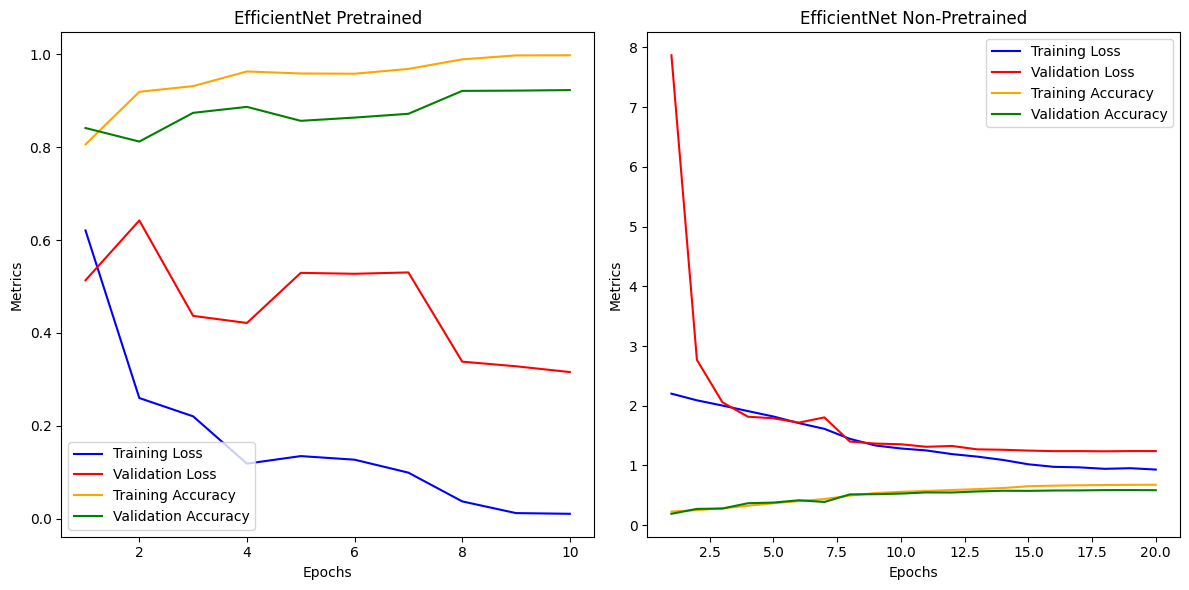

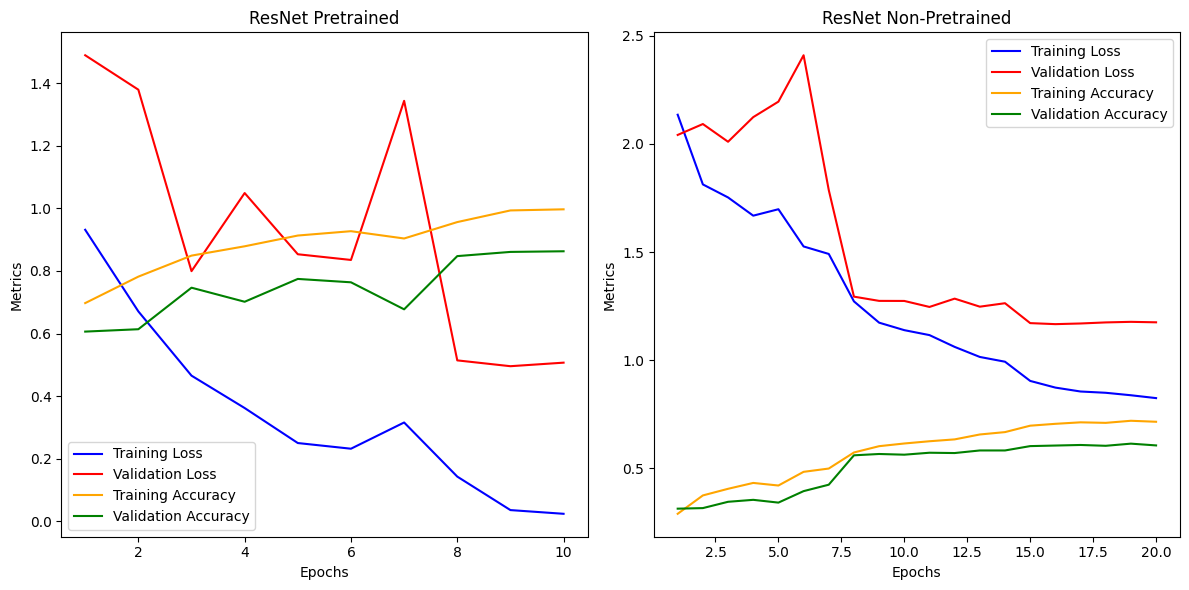

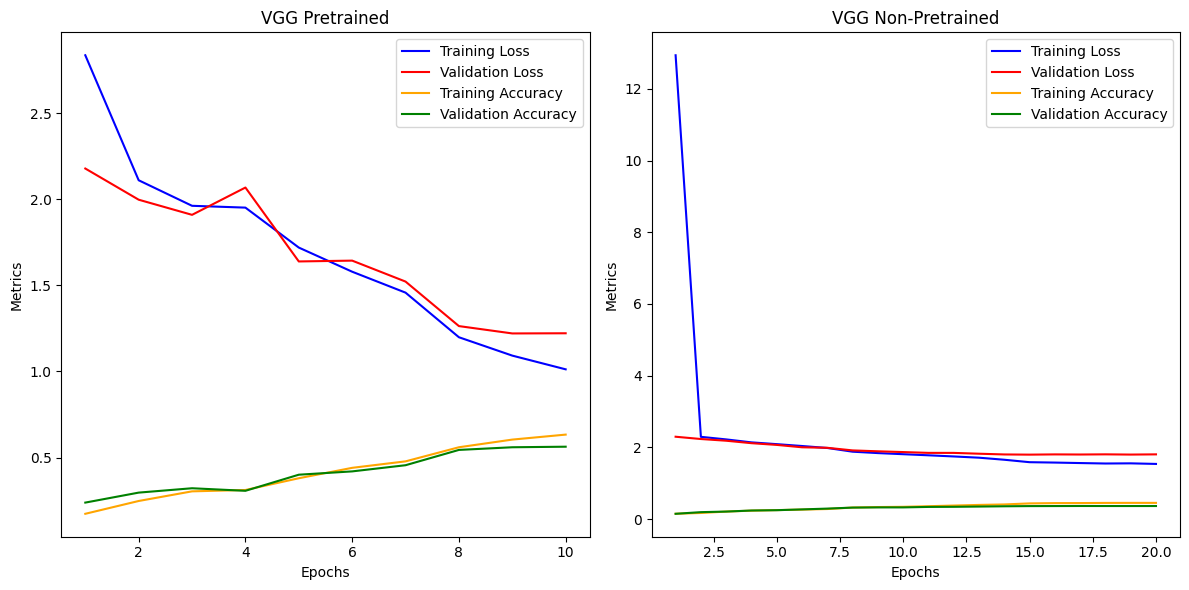

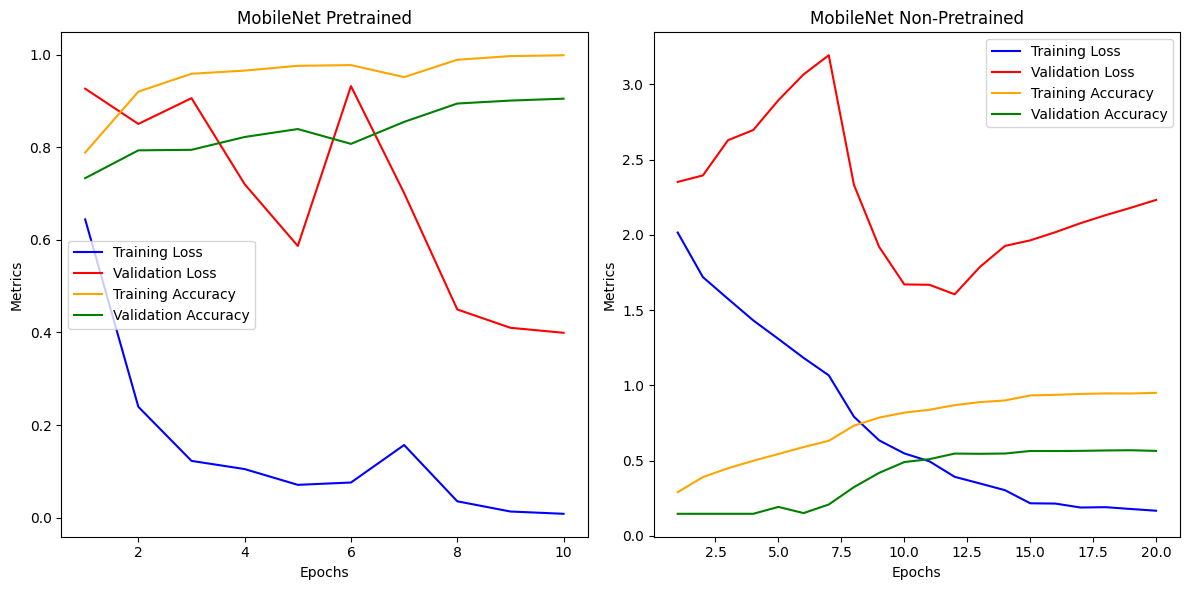

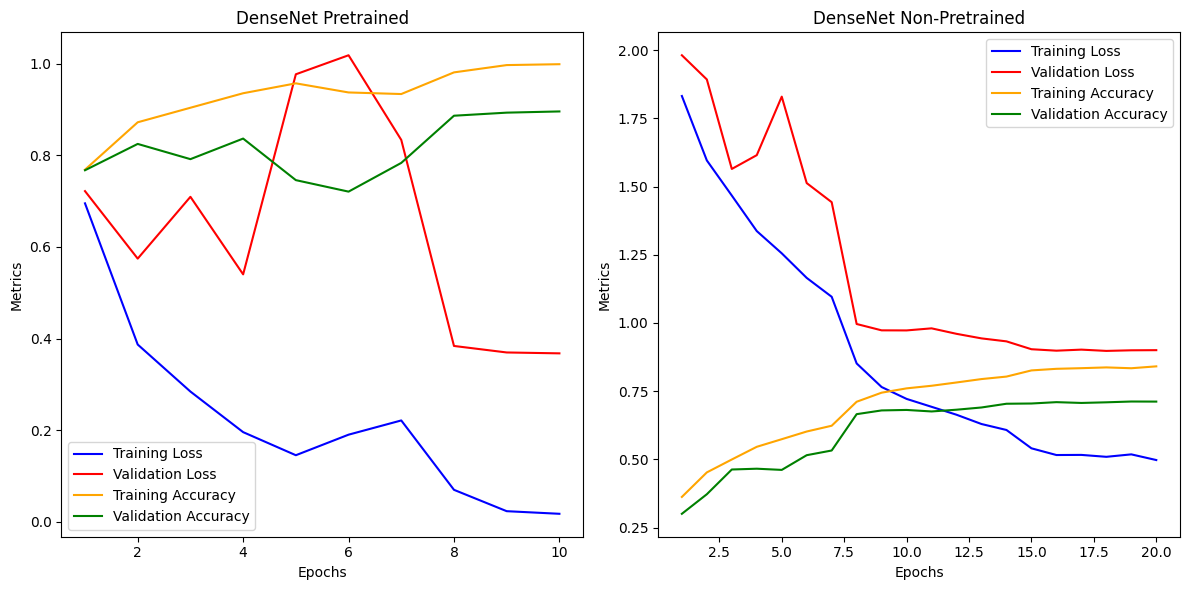

In [19]:
# Plotting
for model_name in pretrained_models.keys():
    pt_epochs_range = range(1, 10 + 1)
    npt_epochs_range = range(1, 20 + 1)
    
    plt.figure(figsize=(12, 6))

    # Plot for pretrained model
    plt.subplot(1, 2, 1)
    plt.plot(pt_epochs_range, pretrained_metrics[model_name]["train_losses"], color='blue', label='Training Loss')
    plt.plot(pt_epochs_range, pretrained_metrics[model_name]["val_losses"], color='red', label='Validation Loss')
    plt.plot(pt_epochs_range, pretrained_metrics[model_name]["train_accuracies"], color='orange', label='Training Accuracy')
    plt.plot(pt_epochs_range, pretrained_metrics[model_name]["val_accuracies"], color='green', label='Validation Accuracy')
    plt.title(f'{model_name} Pretrained')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()

    # Plot for non-pretrained model
    plt.subplot(1, 2, 2)
    plt.plot(npt_epochs_range, non_pretrained_metrics[model_name]["train_losses"], color='blue', label='Training Loss')
    plt.plot(npt_epochs_range, non_pretrained_metrics[model_name]["val_losses"], color='red', label='Validation Loss')
    plt.plot(npt_epochs_range, non_pretrained_metrics[model_name]["train_accuracies"], color='orange', label='Training Accuracy')
    plt.plot(npt_epochs_range, non_pretrained_metrics[model_name]["val_accuracies"], color='green', label='Validation Accuracy')
    plt.title(f'{model_name} Non-Pretrained')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [20]:
with open('pt_metrics.pickle', 'wb') as handle:
    pickle.dump(pretrained_metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('npt_metrics.pickle', 'wb') as handle:
    pickle.dump(non_pretrained_metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)